<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/Constrained_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.stats import norm





In [7]:
def true_objective(X):
    x1, x2 = X[:, 0], X[:, 1]
    return np.sin(3 * x1) + 0.5 * x2

def true_constraint(X):
    x1, x2 = X[:, 0], X[:, 1]
    return 0.5 * np.cos(5 * x1) + 0.3 * x2 - 0.25  # Feasible if <= 0


In [8]:
import numpy as np

def lhs_custom(n_samples, n_dimensions, bounds):
    """
    Latin Hypercube Sampling without pyDOE.

    Parameters:
    - n_samples: number of points to sample
    - n_dimensions: number of input dimensions
    - bounds: list of (min, max) for each dimension

    Returns:
    - X: (n_samples, n_dimensions) array of sampled points
    """
    result = np.zeros((n_samples, n_dimensions))

    # For each dimension, generate stratified samples
    for i in range(n_dimensions):
        lb, ub = bounds[i]
        intervals = np.linspace(0, 1, n_samples + 1)
        lower_bounds = intervals[:-1]
        upper_bounds = intervals[1:]

        points = np.random.uniform(low=lower_bounds, high=upper_bounds)
        np.random.shuffle(points)

        # Scale to actual bounds
        result[:, i] = lb + points * (ub - lb)

    return result


In [9]:
from scipy.stats import norm

def expected_constrained_improvement(x, surrogate_obj_gp, constraint_gps, constraint_thresholds, y_best, xi=0.01):
    """
    Expected Constrained Improvement (EIC) at point x.

    Parameters:
    - x: array-like shape (d,)
    - surrogate_obj_gp: trained GP for objective
    - constraint_gps: list of trained GPs for constraints
    - constraint_thresholds: list of thresholds (λ_i) for each constraint
    - y_best: best feasible objective observed so far
    - xi: exploration parameter (small value to encourage exploration)

    Returns:
    - negative EIC value (to minimize in optimizer)
    """
    x = np.asarray(x).reshape(1, -1)

    # Predict objective
    mu_obj, sigma_obj = surrogate_obj_gp.predict(x, return_std=True)

    # Compute Expected Improvement
    with np.errstate(divide='warn'):
        Z = (y_best - mu_obj - xi) / sigma_obj
        ei = (y_best - mu_obj - xi) * norm.cdf(Z) + sigma_obj * norm.pdf(Z)
        ei[sigma_obj == 0.0] = 0.0

    # Probability of Feasibility
    prob_feas = 1.0
    for gp_c, lam in zip(constraint_gps, constraint_thresholds):
        mu_c, sigma_c = gp_c.predict(x, return_std=True)
        pf = norm.cdf((lam - mu_c) / sigma_c)
        pf[sigma_c == 0.0] = 0.0
        prob_feas *= pf

    eic = ei * prob_feas
    return float(-eic.ravel()[0])  # Return scalar for optimizer


In [2]:
def run_BO(X_init, y_init_obj, y_init_con, bounds, n_BO_steps, constraint_threshold=0.0, xi=0.01):
    kernel = C(1.0) * Matern(length_scale=0.5, nu=2.5) + WhiteKernel()

    X_train = X_init.copy()
    y_obj = y_init_obj.copy()
    y_con = y_init_con.copy()
    best_obj_vals = []

    for i in range(n_BO_steps):
        gp_obj = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        gp_con = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

        gp_obj.fit(X_train, y_obj)
        gp_con.fit(X_train, y_con)

        feasible_idx = np.where(y_con <= constraint_threshold)[0]
        y_best_feasible = np.min(y_obj[feasible_idx]) if len(feasible_idx) > 0 else np.min(y_obj)

        # Grid search for next best point (can be replaced by scipy.optimize)
        grid = np.array([[x1, x2] for x1 in np.linspace(bounds[0][0], bounds[0][1], 50)
                                   for x2 in np.linspace(bounds[1][0], bounds[1][1], 50)])
        eic_vals = np.array([
            expected_constrained_improvement(x, gp_obj, [gp_con], [constraint_threshold], y_best_feasible, xi)
            for x in grid
        ])
        x_next = grid[np.argmin(eic_vals)]

        # Evaluate true functions
        y_next_obj = true_objective(x_next.reshape(1, -1))[0]
        y_next_con = true_constraint(x_next.reshape(1, -1))[0]

        # Append
        X_train = np.vstack((X_train, x_next.reshape(1, -1)))
        y_obj = np.append(y_obj, y_next_obj)
        y_con = np.append(y_con, y_next_con)

        # Store best feasible objective so far
        feasible_idx = np.where(y_con <= constraint_threshold)[0]
        best_obj_vals.append(np.min(y_obj[feasible_idx]) if len(feasible_idx) > 0 else np.nan)

    return X_train, y_obj, y_con, best_obj_vals


In [12]:
bounds = [(0, 2), (0, 2)]
total_budget = 30

# Case 1: LHS Init
X_lhs = lhs_custom(n_samples=10, n_dimensions=2, bounds=bounds)
y_lhs_obj = true_objective(X_lhs)
y_lhs_con = true_constraint(X_lhs)
_, _, _, best_obj_lhs = run_BO(X_lhs, y_lhs_obj, y_lhs_con, bounds, n_BO_steps=20)




/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

In [ ]:
# Case 2: Random Init
X_rand = np.random.uniform(0, 2, size=(10, 2))
y_rand_obj = true_objective(X_rand)
y_rand_con = true_constraint(X_rand)
_, _, _, best_obj_rand = run_BO(X_rand, y_rand_obj, y_rand_con, bounds, n_BO_steps=20)



In [ ]:
# Case 3: 1 random sample + BO
X_1 = np.random.uniform(0, 2, size=(1, 2))
y_1_obj = true_objective(X_1)
y_1_con = true_constraint(X_1)
_, _, _, best_obj_1 = run_BO(X_1, y_1_obj, y_1_con, bounds, n_BO_steps=29)

In [13]:
# Example for 2D problem
bounds = [(0, 2), (0, 2)]

# Generate LHS points
X_lhs = lhs_custom(n_samples=10, n_dimensions=2, bounds=bounds)

# Evaluate true objective and constraint at those points
y_lhs_obj = true_objective(X_lhs)
y_lhs_con = true_constraint(X_lhs)

# Fit GP models
gp_obj.fit(X_lhs, y_lhs_obj)
gp_con.fit(X_lhs, y_lhs_con)

# Evaluate EIC at a new point
x_test = [1.0, 1.5]
eic_val = expected_constrained_improvement(x_test, gp_obj, [gp_con], [0.0], y_best=np.min(y_lhs_obj))


NameError: name 'gp_obj' is not defined

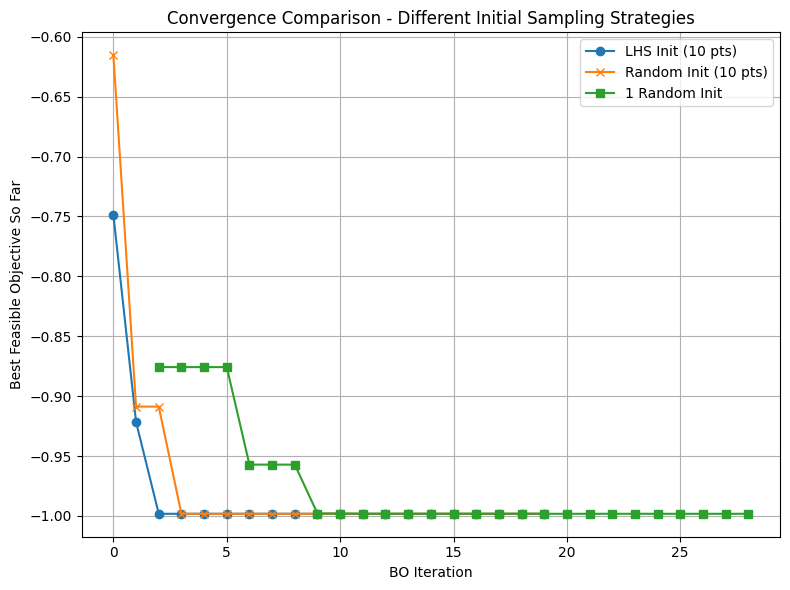

In [14]:
plt.figure(figsize=(8,6))
plt.plot(best_obj_lhs, label='LHS Init (10 pts)', marker='o')
plt.plot(best_obj_rand, label='Random Init (10 pts)', marker='x')
plt.plot(best_obj_1, label='1 Random Init', marker='s')
plt.xlabel("BO Iteration")
plt.ylabel("Best Feasible Objective So Far")
plt.title("Convergence Comparison - Different Initial Sampling Strategies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
